In [1]:
import os
import re

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop
from tensorflow.keras.regularizers import l2

In [2]:
# ------------------------------------------------------------------
# 0) Load & Basic Cleaning
# ------------------------------------------------------------------
data_path = "C:\\Users\\Henry Zhu\\Desktop\\2025_MCM-ICM_Problems\\2025_Problem_C_Data\\summerOly_athletes.csv"
data = pd.read_csv(data_path)

# Remove rows with digits or '.' in 'Team'
df_no_digits = data[~data['Team'].str.contains(r'\d|\.', na=False)]

# Remove rows with Roman numerals in 'Team'
roman_pattern = r'(?:\s|-)M{0,4}(?:CM|CD|D?C{0,3})(?:XC|XL|L?X{0,3})(?:IX|IV|V?I{0,3})(?:\s|$)'
df_no_roman = df_no_digits[~df_no_digits['Team'].str.contains(roman_pattern, na=False, flags=re.IGNORECASE)]

df_raw = df_no_roman.copy()

for col in ["Name","Sex","Team","NOC","City","Sport","Event","Medal"]:
    df_raw[col] = df_raw[col].astype(str)

# Ensure 'Year' is numeric
df_raw["Year"] = pd.to_numeric(df_raw["Year"], errors="coerce")
df_raw.dropna(subset=["Year"], inplace=True)
df_raw["Year"] = df_raw["Year"].astype(int)

print("Initial df_raw shape:", df_raw.shape)

# ------------------------------------------------------------------
# 1) Row-level Transforms (except for NOC)
# ------------------------------------------------------------------
df_filtered = df_raw.copy()

# (1a) Label-encode & scale "Name"
label_encoder_name = LabelEncoder()
df_filtered["Name_Label"] = label_encoder_name.fit_transform(df_filtered["Name"])

scaler_name = MinMaxScaler(feature_range=(0,1))
df_filtered["Name_Label"] = scaler_name.fit_transform(df_filtered[["Name_Label"]])

df_filtered.drop(columns=["Name"], inplace=True)

# (1b) FeatureHash "Team", "Sport", "Event" (NOT NOC)
n_features = 2100  # reduce or enlarge as desired
hasher_team  = FeatureHasher(n_features=n_features, input_type='string')
hasher_sport = FeatureHasher(n_features=n_features, input_type='string')
hasher_event = FeatureHasher(n_features=n_features, input_type='string')

for col, hasher_obj, prefix in [
    ("Team",  hasher_team,  "Team_hashed_"),
    ("Sport", hasher_sport, "Sport_hashed_"),
    ("Event", hasher_event, "Event_hashed_"),
]:
    hashed = hasher_obj.transform(df_filtered[col].apply(lambda x: [x]))
    hashed_df = pd.DataFrame.sparse.from_spmatrix(
        hashed,
        columns=[f"{prefix}{i}" for i in range(n_features)]
    )
    df_filtered.drop(columns=[col], inplace=True)
    df_filtered.reset_index(drop=True, inplace=True)
    hashed_df.reset_index(drop=True, inplace=True)
    df_filtered = pd.concat([df_filtered, hashed_df], axis=1)

# (1c) One-hot for "Sex","City","Medal"
ohe = OneHotEncoder(handle_unknown="ignore")
ohe_array = ohe.fit_transform(df_filtered[["Sex","City","Medal"]])
ohe_cols  = ohe.get_feature_names_out(["Sex","City","Medal"])
ohe_df    = pd.DataFrame(ohe_array.toarray(), columns=ohe_cols)

df_filtered.drop(columns=["Sex","City","Medal"], inplace=True)
df_filtered.reset_index(drop=True, inplace=True)
ohe_df.reset_index(drop=True, inplace=True)
df_filtered = pd.concat([df_filtered, ohe_df], axis=1)

print("After row-level transforms, df_filtered shape:", df_filtered.shape)

# ------------------------------------------------------------------
# 2) Group by (Year, NOC)
# ------------------------------------------------------------------
# We'll group each country-year as a single row, summing hashed columns.
df_filtered["Year"] = df_filtered["Year"].astype(int)

grouped_cols = df_filtered.drop(
    columns=["Medal_Gold","Medal_Silver","Medal_Bronze","Year"], 
    errors="ignore"
).columns.difference(["NOC"])

df_agg = df_filtered.groupby(["Year","NOC"], as_index=False).agg({c:"sum" for c in grouped_cols})
df_agg = df_agg.merge(
    df_filtered.groupby(["Year","NOC"], as_index=False).agg({
        "Medal_Gold":"sum","Medal_Silver":"sum","Medal_Bronze":"sum"
    }),
    on=["Year","NOC"], how="left"
)

print("Grouped by (Year, NOC) shape:", df_agg.shape)

# ------------------------------------------------------------------
# 3) Encode NOC at the aggregated level
# ------------------------------------------------------------------
# We'll one-hot encode NOC here. If you have many NOCs, consider label encoding or hashing NOC alone.
ohe_noc = OneHotEncoder(handle_unknown="ignore")
noc_arr = ohe_noc.fit_transform(df_agg[["NOC"]])
noc_cols = [f"NOC_{cat}" for cat in ohe_noc.categories_[0]]
noc_df   = pd.DataFrame(noc_arr.toarray(), columns=noc_cols)

df_agg.reset_index(drop=True, inplace=True)
noc_df.reset_index(drop=True, inplace=True)

df_agg = pd.concat([df_agg.drop(columns=["NOC"]), noc_df], axis=1)

print("After NOC encoding, df_agg shape:", df_agg.shape)

# Convert numeric
num_cols = df_agg.select_dtypes(include=["number"]).columns
df_agg[num_cols] = df_agg[num_cols].astype("float32")
df_agg["Year"]   = df_agg["Year"].astype("int32")

# ------------------------------------------------------------------
# Scale Features / Targets
# ------------------------------------------------------------------

from sklearn.preprocessing import StandardScaler

feature_cols = df_agg.drop(columns=["Year","Medal_Gold","Medal_Silver","Medal_Bronze"]).columns
target_cols  = ["Medal_Gold","Medal_Silver","Medal_Bronze"]

scaler_features = StandardScaler()
scaler_targets  = StandardScaler()

# We'll store scaled data in new DataFrames
df_agg_scaled = df_agg.copy()

X_to_scale = df_agg_scaled[feature_cols].values
y_to_scale = df_agg_scaled[target_cols].values

X_scaled = scaler_features.fit_transform(X_to_scale)
y_scaled = scaler_targets.fit_transform(y_to_scale)

df_agg_scaled[feature_cols] = X_scaled
df_agg_scaled[target_cols]  = y_scaled

print("df_agg_scaled shape:", df_agg_scaled.shape)


Initial df_raw shape: (249329, 9)
After row-level transforms, df_filtered shape: (249329, 6332)
Grouped by (Year, NOC) shape: (3222, 6332)
After NOC encoding, df_agg shape: (3222, 6565)
df_agg_scaled shape: (3222, 6565)


In [17]:
# ------------------------------------------------------------------
# 4) Train-Test Split (chronological on Year)
# ------------------------------------------------------------------
split_year = 2016
train_df = df_agg_scaled[df_agg_scaled["Year"] < split_year].copy()
test_df  = df_agg_scaled[df_agg_scaled["Year"] >= split_year].copy()

X_train = train_df.drop(columns=["Year"] + target_cols)
y_train = train_df[target_cols]

X_test  = test_df.drop(columns=["Year"] + target_cols)
y_test  = test_df[target_cols]

model_input_columns = X_train.columns.tolist()

print("Train shape:", X_train.shape, y_train.shape)
print("Test  shape:", X_test.shape, y_test.shape)

# ------------------------------------------------------------------
# 5) Build & Train a Deeper FFNN with Callbacks & Cross-Validation
# ------------------------------------------------------------------

# Set environment variables for multi-threading
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"

tf.config.threading.set_intra_op_parallelism_threads(20)
tf.config.threading.set_inter_op_parallelism_threads(20)

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def build_nn_model(input_dim):
    model = Sequential([
        tf.keras.Input(shape=(input_dim,)),

        Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.2),

        Dense(64, activation='swish'),
        Dropout(0.1),

        Dense(64, activation='swish'),
        Dense(3, activation='linear')  # Predicting Gold, Silver, Bronze
    ])
    optimizer = AdamW(learning_rate=0.0005, weight_decay=1e-5)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Initialize model
nn_model = build_nn_model(X_train.shape[1])

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

# ------------------------------------------------------------------
# Time Series Cross-Validation
# ------------------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=5)
cv_results = []

for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    print(f"\nTraining on {len(train_index)} samples, validating on {len(val_index)} samples.")

    history = nn_model.fit(
        X_train_fold, y_train_fold,
        epochs=300,
        batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop, reduce_lr],
        verbose=2
    )

    val_predictions = nn_model.predict(X_val_fold)
    val_mae = mean_absolute_error(y_val_fold, val_predictions)
    cv_results.append(val_mae)
    print(f"Fold Validation MAE: {val_mae:.4f}")

print(f"\nAverage CV MAE: {np.mean(cv_results):.4f}")

# ------------------------------------------------------------------
# Final Training & Testing
# ------------------------------------------------------------------
if not X_test.empty:
    print("\nTraining on the full train dataset and testing on unseen data...")
    history = nn_model.fit(
        X_train, y_train,
        epochs=300,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stop, reduce_lr],
        verbose=2
    )
    final_loss, final_mae = nn_model.evaluate(X_test, y_test, verbose=0)
    print("Final Test Loss:", final_loss, "MAE:", final_mae)
else:
    print("No test set to evaluate.")

Train shape: (2603, 6561) (2603, 3)
Test  shape: (619, 6561) (619, 3)

Training on 438 samples, validating on 433 samples.
Epoch 1/300
14/14 - 2s - 143ms/step - loss: 13.5495 - mae: 0.6460 - val_loss: 10.5405 - val_mae: 0.4372 - learning_rate: 5.0000e-04
Epoch 2/300
14/14 - 0s - 20ms/step - loss: 9.3960 - mae: 0.5120 - val_loss: 8.0177 - val_mae: 0.3940 - learning_rate: 5.0000e-04
Epoch 3/300
14/14 - 0s - 26ms/step - loss: 7.4397 - mae: 0.4380 - val_loss: 6.8350 - val_mae: 0.3644 - learning_rate: 5.0000e-04
Epoch 4/300
14/14 - 0s - 20ms/step - loss: 6.4943 - mae: 0.4000 - val_loss: 6.2971 - val_mae: 0.3440 - learning_rate: 5.0000e-04
Epoch 5/300
14/14 - 0s - 20ms/step - loss: 6.0479 - mae: 0.3629 - val_loss: 6.0279 - val_mae: 0.3372 - learning_rate: 5.0000e-04
Epoch 6/300
14/14 - 0s - 20ms/step - loss: 5.8045 - mae: 0.3500 - val_loss: 5.8453 - val_mae: 0.3233 - learning_rate: 5.0000e-04
Epoch 7/300
14/14 - 0s - 20ms/step - loss: 5.5657 - mae: 0.3221 - val_loss: 5.6808 - val_mae: 0.3118

In [31]:
# ------------------------------------------------------------------
# 6) Prediction Utility for a Single (NOC,Year)
# ------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

def predict_extrapolated_noc_year(
    noc_code, 
    year_value,
    df_agg,              # Unscaled aggregator DataFrame with columns: Year, NOC_{xxx}, and numeric features
    scaler_features,     # The fitted feature scaler (StandardScaler/MinMaxScaler)
    scaler_targets,      # The fitted target scaler
    nn_model,            # Your trained model
    feature_cols,        # List of columns used for model input
    target_cols=["Medal_Gold","Medal_Silver","Medal_Bronze"],
    max_history_medals=10,
    max_close_points=8
):
    """
    Creates a new "extrapolated" row for (Year=year_value, NOC=noc_code) using polynomial
    regression (degree 2 to 4) on up to 'max_close_points' existing data from the same NOC,
    for each numeric feature. That predicted "base" is used instead of zeros.

    Steps:
      1) Print up to 'max_history_medals' past data points for that NOC (debugging).
      2) Gather up to 'max_close_points' aggregator rows from 'df_agg' with the smallest
         year-distance from 'year_value'.
      3) For each feature in 'feature_cols' (except 'NOC_*','Year','Medal_*'):
         - Fit polynomials of degree in [2,3,4] to (year -> feature value) on those points.
         - Pick the best degree by minimal MSE. Evaluate at 'year_value'.
      4) Fill the new row with those predicted feature values, set 'NOC_{noc_code}' to 1,
         other 'NOC_*' to 0, and 'Year'=year_value.
      5) Scale & feed to nn_model. Invert the target scaling for final predictions.
    """

    # 1) Print medal history for debugging
    #    Filter all rows for this NOC, sorted by year, tail() for up to 10 data points
    noc_col = f"NOC_{noc_code}"
    if noc_col not in df_agg.columns:
        print(f"[Extrapolation] Column {noc_col} not in df_agg. No data for NOC={noc_code}.")
        return None
    
    df_noc_all = df_agg[df_agg[noc_col] == 1].copy()
    df_noc_all_sorted = df_noc_all.sort_values("Year")
    if not df_noc_all_sorted.empty:
        print(f"[Debug] Medal history for NOC={noc_code} (up to last {max_history_medals} rows):")
        display(df_noc_all_sorted[["Year"]+target_cols].tail(max_history_medals))
    else:
        print(f"[Debug] No existing data for NOC={noc_code} in df_agg.")

    # 2) Gather up to 'max_close_points' aggregator rows from that NOC,
    #    sorted by absolute difference from 'year_value'
    df_noc_all_sorted["year_diff"] = (df_noc_all_sorted["Year"] - year_value).abs()
    df_noc_closest = df_noc_all_sorted.nsmallest(max_close_points, "year_diff").copy()
    # If this is empty or we have no data, we'll fallback to zeros for all columns
    # but let's keep going

    # 3) Construct an empty row
    empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)
    empty_row["Year"] = float(year_value)

    # If we have the NOC col, set it to 1, and set other NOC_... to 0
    for c in df_agg.columns:
        if c.startswith("NOC_"):
            empty_row[c] = 1.0 if c == noc_col else 0.0

    # For each feature in feature_cols, we take a moving average if it isn't "NOC_", "Year", or "Medal_"
    def moving_average_baseline(x_vals, y_vals, year_value, window=3):
        """
        Computes a moving average using numpy arrays instead of DataFrame operations.
        """
        valid_indices = x_vals < year_value  # Filter past years only
        if np.sum(valid_indices) < window:
            window = np.sum(valid_indices)  # Adjust window size
    
        if window < 1:
            return np.mean(y_vals)  # Return mean if insufficient data
    
        sorted_indices = np.argsort(x_vals[valid_indices])
        moving_avg = np.mean(y_vals[valid_indices][sorted_indices][-window:])
        return moving_avg



    # We'll gather the (Year -> feature) pairs from df_noc_closest and do polynomial on them
    for col in feature_cols:
        # Skip if it's Year or NOC_ or Medal_ columns
        if col.startswith("NOC_") or col.startswith("Medal_") or col == "Year":
            continue
        # Extract existing data from df_noc_closest
        if col not in df_noc_closest.columns:
            # fallback to zero if col doesn't exist
            empty_row[col] = 0.0
            continue
        
        # valid rows for this col (some might be float columns)
        valid_rows = df_noc_closest[~df_noc_closest[col].isna()].copy()
        if valid_rows.empty:
            empty_row[col] = 0.0
            continue
        
        # x = year, y = feature value
        x_vals = valid_rows["Year"].to_numpy().astype(float)
        y_vals = valid_rows[col].to_numpy().astype(float)

        pred_val = moving_average_baseline(x_vals, y_vals, year_value)
        empty_row[col] = pred_val

    # 4) Now we have a "predicted" row for the new year
    #    Separate out features
    X_unscaled = empty_row[feature_cols].copy()
    # 5) Scale
    X_scaled = scaler_features.transform(X_unscaled)

    # 6) Predict in scaled space
    preds_scaled = nn_model.predict(X_scaled)

    # 7) Invert scaling -> real medal counts
    preds_real = scaler_targets.inverse_transform(preds_scaled)
    gold, silver, bronze = preds_real[0]

    print(f"\n[Extrapolated] Predicted medals for NOC={noc_code}, Year={year_value}:")
    print(f"  Gold={gold:.1f}, Silver={silver:.1f}, Bronze={bronze:.1f}")
    return (gold, silver, bronze)


predict_extrapolated_noc_year(
    noc_code="CHN",
    year_value=2020,
    df_agg=df_agg,
    scaler_features=scaler_features,
    scaler_targets=scaler_targets,
    nn_model=nn_model,
    feature_cols=feature_cols
)

[Debug] Medal history for NOC=CHN (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1299,1988,4.0,16.0,30.0
1459,1992,14.0,41.0,15.0
1635,1996,13.0,66.0,15.0
1831,2000,31.0,19.0,15.0
2032,2004,42.0,27.0,13.0
2232,2008,72.0,49.0,49.0
2436,2012,50.0,38.0,29.0
2641,2016,44.0,30.0,35.0
2848,2020,59.0,49.0,33.0
3054,2024,71.0,57.0,40.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

[Extrapolated] Predicted medals for NOC=CHN, Year=2020:
  Gold=34.8, Silver=24.2, Bronze=31.7


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(34.839764, 24.19242, 31.703182)


Predicting for NOC=CHN, Year=2012
[Debug] Medal history for NOC=CHN (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1299,1988,4.0,16.0,30.0
1459,1992,14.0,41.0,15.0
1635,1996,13.0,66.0,15.0
1831,2000,31.0,19.0,15.0
2032,2004,42.0,27.0,13.0
2232,2008,72.0,49.0,49.0
2436,2012,50.0,38.0,29.0
2641,2016,44.0,30.0,35.0
2848,2020,59.0,49.0,33.0
3054,2024,71.0,57.0,40.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

[Extrapolated] Predicted medals for NOC=CHN, Year=2012:
  Gold=29.3, Silver=21.0, Bronze=29.6
Predicted medals: Gold=29.3, Silver=21.0, Bronze=29.6
Actual medals: Gold=50.0, Silver=38.0, Bronze=29.0

Predicting for NOC=USA, Year=2012
[Debug] Medal history for NOC=USA (up to last 10 rows):


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1417,1988,87.0,66.0,54.0
1588,1992,87.0,50.0,85.0
1784,1996,157.0,46.0,52.0
1984,2000,128.0,61.0,51.0
2185,2004,115.0,75.0,69.0
2389,2008,121.0,110.0,78.0
2594,2012,139.0,55.0,44.0
2801,2016,137.0,52.0,67.0
3007,2020,113.0,110.0,75.0
3213,2024,131.0,96.0,94.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

[Extrapolated] Predicted medals for NOC=USA, Year=2012:
  Gold=80.0, Silver=37.4, Bronze=41.6
Predicted medals: Gold=80.0, Silver=37.4, Bronze=41.6
Actual medals: Gold=139.0, Silver=55.0, Bronze=44.0

Predicting for NOC=GBR, Year=2012
[Debug] Medal history for NOC=GBR (up to last 10 rows):


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1320,1988,22.0,17.0,15.0
1484,1992,8.0,3.0,39.0
1663,1996,2.0,15.0,9.0
1861,2000,22.0,20.0,10.0
2061,2004,17.0,23.0,15.0
2262,2008,31.0,25.0,25.0
2466,2012,46.0,28.0,48.0
2671,2016,64.0,55.0,26.0
2879,2020,41.0,43.0,57.0
3085,2024,39.0,41.0,76.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

[Extrapolated] Predicted medals for NOC=GBR, Year=2012:
  Gold=9.6, Silver=16.3, Bronze=12.6
Predicted medals: Gold=9.6, Silver=16.3, Bronze=12.6
Actual medals: Gold=46.0, Silver=28.0, Bronze=48.0

Predicting for NOC=RUS, Year=2012
[Debug] Medal history for NOC=RUS (up to last 10 rows):


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
39,1900,0.0,0.0,0.0
97,1908,1.0,2.0,0.0
123,1912,0.0,5.0,2.0
196,1924,0.0,0.0,0.0
1748,1996,36.0,45.0,34.0
1948,2000,66.0,67.0,54.0
2148,2004,48.0,46.0,95.0
2351,2008,43.0,46.0,53.0
2556,2012,50.0,39.0,49.0
2762,2016,50.0,28.0,35.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=RUS, Year=2012:
  Gold=42.8, Silver=26.6, Bronze=37.0
Predicted medals: Gold=42.8, Silver=26.6, Bronze=37.0
Actual medals: Gold=50.0, Silver=39.0, Bronze=49.0

Predicting for NOC=GER, Year=2012
[Debug] Medal history for NOC=GER (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
660,1964,22.0,44.0,50.0
1486,1992,81.0,57.0,60.0
1667,1996,42.0,35.0,45.0
1865,2000,31.0,23.0,62.0
2065,2004,41.0,43.0,63.0
2266,2008,42.0,16.0,41.0
2470,2012,43.0,27.0,22.0
2675,2016,47.0,43.0,67.0
2883,2020,21.0,26.0,34.0
3089,2024,21.0,49.0,38.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=GER, Year=2012:
  Gold=31.9, Silver=26.1, Bronze=29.6
Predicted medals: Gold=31.9, Silver=26.1, Bronze=29.6
Actual medals: Gold=43.0, Silver=27.0, Bronze=22.0

Predicting for NOC=CHN, Year=2016
[Debug] Medal history for NOC=CHN (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1299,1988,4.0,16.0,30.0
1459,1992,14.0,41.0,15.0
1635,1996,13.0,66.0,15.0
1831,2000,31.0,19.0,15.0
2032,2004,42.0,27.0,13.0
2232,2008,72.0,49.0,49.0
2436,2012,50.0,38.0,29.0
2641,2016,44.0,30.0,35.0
2848,2020,59.0,49.0,33.0
3054,2024,71.0,57.0,40.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

[Extrapolated] Predicted medals for NOC=CHN, Year=2016:
  Gold=35.4, Silver=24.2, Bronze=31.8
Predicted medals: Gold=35.4, Silver=24.2, Bronze=31.8
Actual medals: Gold=44.0, Silver=30.0, Bronze=35.0

Predicting for NOC=USA, Year=2016
[Debug] Medal history for NOC=USA (up to last 10 rows):


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1417,1988,87.0,66.0,54.0
1588,1992,87.0,50.0,85.0
1784,1996,157.0,46.0,52.0
1984,2000,128.0,61.0,51.0
2185,2004,115.0,75.0,69.0
2389,2008,121.0,110.0,78.0
2594,2012,139.0,55.0,44.0
2801,2016,137.0,52.0,67.0
3007,2020,113.0,110.0,75.0
3213,2024,131.0,96.0,94.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=USA, Year=2016:
  Gold=78.7, Silver=36.6, Bronze=40.9
Predicted medals: Gold=78.7, Silver=36.6, Bronze=40.9
Actual medals: Gold=137.0, Silver=52.0, Bronze=67.0

Predicting for NOC=GBR, Year=2016
[Debug] Medal history for NOC=GBR (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1320,1988,22.0,17.0,15.0
1484,1992,8.0,3.0,39.0
1663,1996,2.0,15.0,9.0
1861,2000,22.0,20.0,10.0
2061,2004,17.0,23.0,15.0
2262,2008,31.0,25.0,25.0
2466,2012,46.0,28.0,48.0
2671,2016,64.0,55.0,26.0
2879,2020,41.0,43.0,57.0
3085,2024,39.0,41.0,76.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=GBR, Year=2016:
  Gold=11.5, Silver=18.2, Bronze=14.3
Predicted medals: Gold=11.5, Silver=18.2, Bronze=14.3
Actual medals: Gold=64.0, Silver=55.0, Bronze=26.0

Predicting for NOC=RUS, Year=2016
[Debug] Medal history for NOC=RUS (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
39,1900,0.0,0.0,0.0
97,1908,1.0,2.0,0.0
123,1912,0.0,5.0,2.0
196,1924,0.0,0.0,0.0
1748,1996,36.0,45.0,34.0
1948,2000,66.0,67.0,54.0
2148,2004,48.0,46.0,95.0
2351,2008,43.0,46.0,53.0
2556,2012,50.0,39.0,49.0
2762,2016,50.0,28.0,35.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=RUS, Year=2016:
  Gold=39.8, Silver=23.6, Bronze=34.8
Predicted medals: Gold=39.8, Silver=23.6, Bronze=34.8
Actual medals: Gold=50.0, Silver=28.0, Bronze=35.0

Predicting for NOC=GER, Year=2016
[Debug] Medal history for NOC=GER (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
660,1964,22.0,44.0,50.0
1486,1992,81.0,57.0,60.0
1667,1996,42.0,35.0,45.0
1865,2000,31.0,23.0,62.0
2065,2004,41.0,43.0,63.0
2266,2008,42.0,16.0,41.0
2470,2012,43.0,27.0,22.0
2675,2016,47.0,43.0,67.0
2883,2020,21.0,26.0,34.0
3089,2024,21.0,49.0,38.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

[Extrapolated] Predicted medals for NOC=GER, Year=2016:
  Gold=29.9, Silver=25.4, Bronze=27.7
Predicted medals: Gold=29.9, Silver=25.4, Bronze=27.7
Actual medals: Gold=47.0, Silver=43.0, Bronze=67.0

Predicting for NOC=CHN, Year=2020
[Debug] Medal history for NOC=CHN (up to last 10 rows):


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1299,1988,4.0,16.0,30.0
1459,1992,14.0,41.0,15.0
1635,1996,13.0,66.0,15.0
1831,2000,31.0,19.0,15.0
2032,2004,42.0,27.0,13.0
2232,2008,72.0,49.0,49.0
2436,2012,50.0,38.0,29.0
2641,2016,44.0,30.0,35.0
2848,2020,59.0,49.0,33.0
3054,2024,71.0,57.0,40.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=CHN, Year=2020:
  Gold=34.8, Silver=24.2, Bronze=31.7
Predicted medals: Gold=34.8, Silver=24.2, Bronze=31.7
Actual medals: Gold=59.0, Silver=49.0, Bronze=33.0

Predicting for NOC=USA, Year=2020
[Debug] Medal history for NOC=USA (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1417,1988,87.0,66.0,54.0
1588,1992,87.0,50.0,85.0
1784,1996,157.0,46.0,52.0
1984,2000,128.0,61.0,51.0
2185,2004,115.0,75.0,69.0
2389,2008,121.0,110.0,78.0
2594,2012,139.0,55.0,44.0
2801,2016,137.0,52.0,67.0
3007,2020,113.0,110.0,75.0
3213,2024,131.0,96.0,94.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=USA, Year=2020:
  Gold=80.3, Silver=36.7, Bronze=41.2
Predicted medals: Gold=80.3, Silver=36.7, Bronze=41.2
Actual medals: Gold=113.0, Silver=110.0, Bronze=75.0

Predicting for NOC=GBR, Year=2020
[Debug] Medal history for NOC=GBR (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1320,1988,22.0,17.0,15.0
1484,1992,8.0,3.0,39.0
1663,1996,2.0,15.0,9.0
1861,2000,22.0,20.0,10.0
2061,2004,17.0,23.0,15.0
2262,2008,31.0,25.0,25.0
2466,2012,46.0,28.0,48.0
2671,2016,64.0,55.0,26.0
2879,2020,41.0,43.0,57.0
3085,2024,39.0,41.0,76.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=GBR, Year=2020:
  Gold=15.0, Silver=21.9, Bronze=17.6
Predicted medals: Gold=15.0, Silver=21.9, Bronze=17.6
Actual medals: Gold=41.0, Silver=43.0, Bronze=57.0

Predicting for NOC=RUS, Year=2020
[Debug] Medal history for NOC=RUS (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
39,1900,0.0,0.0,0.0
97,1908,1.0,2.0,0.0
123,1912,0.0,5.0,2.0
196,1924,0.0,0.0,0.0
1748,1996,36.0,45.0,34.0
1948,2000,66.0,67.0,54.0
2148,2004,48.0,46.0,95.0
2351,2008,43.0,46.0,53.0
2556,2012,50.0,39.0,49.0
2762,2016,50.0,28.0,35.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=RUS, Year=2020:
  Gold=31.4, Silver=18.7, Bronze=30.5
Predicted medals: Gold=31.4, Silver=18.7, Bronze=30.5
No actual data for NOC=RUS, Year=2020

Predicting for NOC=GER, Year=2020
[Debug] Medal history for NOC=GER (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
660,1964,22.0,44.0,50.0
1486,1992,81.0,57.0,60.0
1667,1996,42.0,35.0,45.0
1865,2000,31.0,23.0,62.0
2065,2004,41.0,43.0,63.0
2266,2008,42.0,16.0,41.0
2470,2012,43.0,27.0,22.0
2675,2016,47.0,43.0,67.0
2883,2020,21.0,26.0,34.0
3089,2024,21.0,49.0,38.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=GER, Year=2020:
  Gold=31.0, Silver=25.2, Bronze=29.4
Predicted medals: Gold=31.0, Silver=25.2, Bronze=29.4
Actual medals: Gold=21.0, Silver=26.0, Bronze=34.0

Predicting for NOC=CHN, Year=2024
[Debug] Medal history for NOC=CHN (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1299,1988,4.0,16.0,30.0
1459,1992,14.0,41.0,15.0
1635,1996,13.0,66.0,15.0
1831,2000,31.0,19.0,15.0
2032,2004,42.0,27.0,13.0
2232,2008,72.0,49.0,49.0
2436,2012,50.0,38.0,29.0
2641,2016,44.0,30.0,35.0
2848,2020,59.0,49.0,33.0
3054,2024,71.0,57.0,40.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

[Extrapolated] Predicted medals for NOC=CHN, Year=2024:
  Gold=27.3, Silver=13.1, Bronze=25.9
Predicted medals: Gold=27.3, Silver=13.1, Bronze=25.9
Actual medals: Gold=71.0, Silver=57.0, Bronze=40.0

Predicting for NOC=USA, Year=2024
[Debug] Medal history for NOC=USA (up to last 10 rows):


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1417,1988,87.0,66.0,54.0
1588,1992,87.0,50.0,85.0
1784,1996,157.0,46.0,52.0
1984,2000,128.0,61.0,51.0
2185,2004,115.0,75.0,69.0
2389,2008,121.0,110.0,78.0
2594,2012,139.0,55.0,44.0
2801,2016,137.0,52.0,67.0
3007,2020,113.0,110.0,75.0
3213,2024,131.0,96.0,94.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=USA, Year=2024:
  Gold=77.9, Silver=28.5, Bronze=40.9
Predicted medals: Gold=77.9, Silver=28.5, Bronze=40.9
Actual medals: Gold=131.0, Silver=96.0, Bronze=94.0

Predicting for NOC=GBR, Year=2024
[Debug] Medal history for NOC=GBR (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
1320,1988,22.0,17.0,15.0
1484,1992,8.0,3.0,39.0
1663,1996,2.0,15.0,9.0
1861,2000,22.0,20.0,10.0
2061,2004,17.0,23.0,15.0
2262,2008,31.0,25.0,25.0
2466,2012,46.0,28.0,48.0
2671,2016,64.0,55.0,26.0
2879,2020,41.0,43.0,57.0
3085,2024,39.0,41.0,76.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

[Extrapolated] Predicted medals for NOC=GBR, Year=2024:
  Gold=13.1, Silver=17.7, Bronze=19.8
Predicted medals: Gold=13.1, Silver=17.7, Bronze=19.8
Actual medals: Gold=39.0, Silver=41.0, Bronze=76.0

Predicting for NOC=RUS, Year=2024
[Debug] Medal history for NOC=RUS (up to last 10 rows):


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
39,1900,0.0,0.0,0.0
97,1908,1.0,2.0,0.0
123,1912,0.0,5.0,2.0
196,1924,0.0,0.0,0.0
1748,1996,36.0,45.0,34.0
1948,2000,66.0,67.0,54.0
2148,2004,48.0,46.0,95.0
2351,2008,43.0,46.0,53.0
2556,2012,50.0,39.0,49.0
2762,2016,50.0,28.0,35.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=RUS, Year=2024:
  Gold=31.4, Silver=18.7, Bronze=30.5
Predicted medals: Gold=31.4, Silver=18.7, Bronze=30.5
No actual data for NOC=RUS, Year=2024

Predicting for NOC=GER, Year=2024
[Debug] Medal history for NOC=GER (up to last 10 rows):


,Year,Medal_Gold,Medal_Silver,Medal_Bronze
660,1964,22.0,44.0,50.0
1486,1992,81.0,57.0,60.0
1667,1996,42.0,35.0,45.0
1865,2000,31.0,23.0,62.0
2065,2004,41.0,43.0,63.0
2266,2008,42.0,16.0,41.0
2470,2012,43.0,27.0,22.0
2675,2016,47.0,43.0,67.0
2883,2020,21.0,26.0,34.0
3089,2024,21.0,49.0,38.0


C:\Users\Henry Zhu\AppData\Local\Temp\ipykernel_2692\3886155821.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_row = pd.DataFrame(columns=df_agg.columns, index=[0]).fillna(0.0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


E:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



[Extrapolated] Predicted medals for NOC=GER, Year=2024:
  Gold=23.4, Silver=13.6, Bronze=26.6
Predicted medals: Gold=23.4, Silver=13.6, Bronze=26.6
Actual medals: Gold=21.0, Silver=49.0, Bronze=38.0

Prediction vs Actual Summary:


,NOC,Year,Gold_Predicted,Silver_Predicted,Bronze_Predicted,Gold_Actual,Silver_Actual,Bronze_Actual,Gold_Error_Pct,Silver_Error_Pct,Bronze_Error_Pct
0,CHN,2012,29.253687,21.019611,29.622604,50.0,38.0,29.0,41.492626,44.685233,2.146912
1,USA,2012,79.952843,37.352993,41.643990,139.0,55.0,44.0,42.479969,32.085467,5.354569
2,GBR,2012,9.645769,16.347416,12.619681,46.0,28.0,48.0,79.030937,41.616372,73.708997
3,RUS,2012,42.775246,26.644657,36.951443,50.0,39.0,49.0,14.449509,31.680366,24.588892
4,GER,2012,31.868126,26.149736,29.576557,43.0,27.0,22.0,25.888079,3.149124,34.438896
5,CHN,2016,35.415104,24.190081,31.788765,44.0,30.0,35.0,19.511127,19.366398,9.174957
6,USA,2016,78.721161,36.585896,40.886162,137.0,52.0,67.0,42.539299,29.642509,38.975878
7,GBR,2016,11.450920,18.190201,14.337427,64.0,55.0,26.0,82.107937,66.926908,44.856049
8,RUS,2016,39.790421,23.629026,34.829044,50.0,28.0,35.0,20.419159,15.610620,0.488445
9,GER,2016,29.881506,25.417639,27.661968,47.0,43.0,67.0,36.422328,40.889212,58.713480


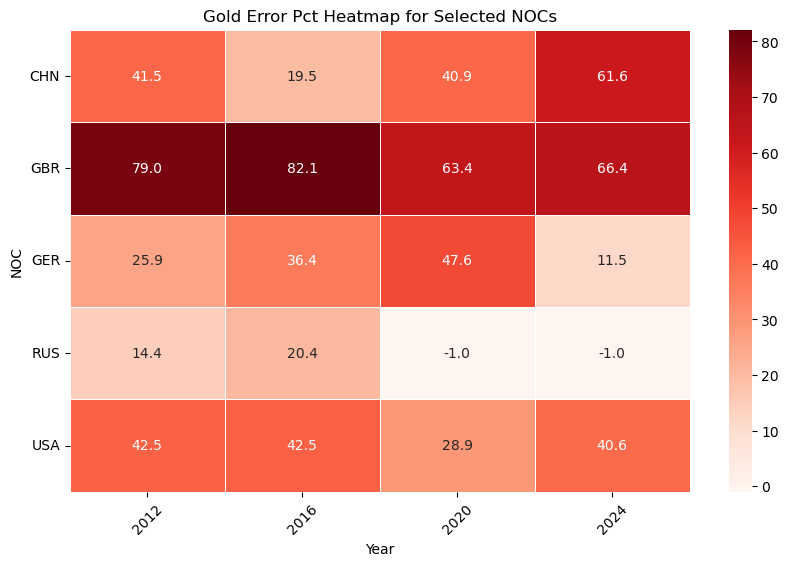

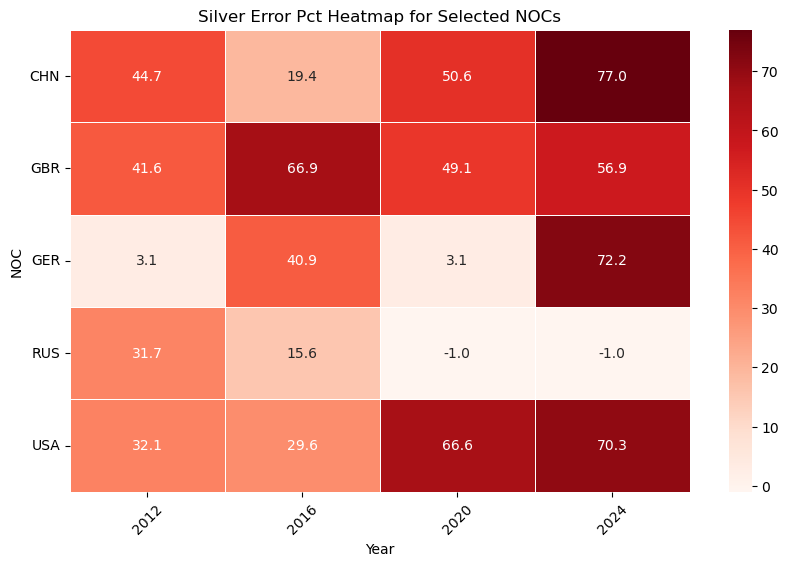

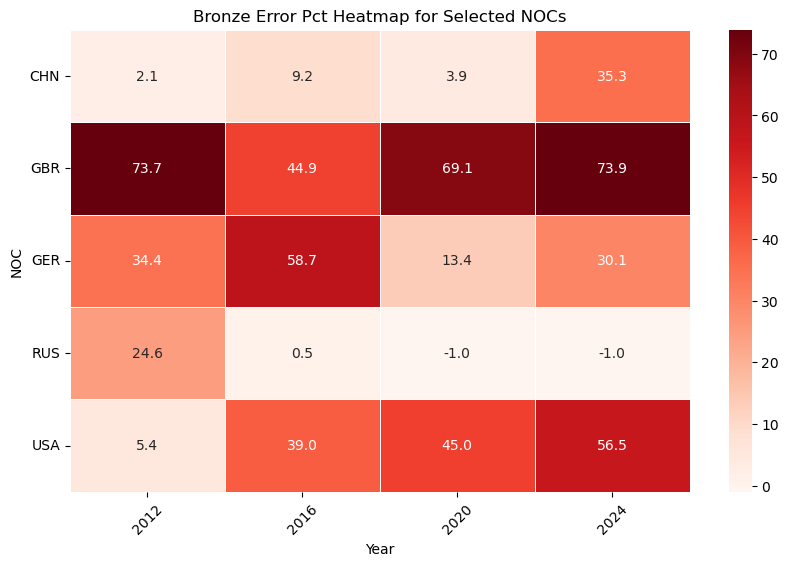

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

def predict_and_compare(noc_list, df_agg, scaler_features, scaler_targets, nn_model, feature_cols, check_years=[2012, 2016, 2020, 2024], show_history=False):
    """
    Predicts medal counts using the trained model and compares with actual data.

    Parameters:
        noc_list (list): List of NOCs to predict and compare.
        df_agg (pd.DataFrame): Aggregated dataframe with historical data.
        scaler_features (StandardScaler): Scaler for feature normalization.
        scaler_targets (StandardScaler): Scaler for target values.
        nn_model (Sequential): Trained neural network model.
        feature_cols (list): Columns used for model input.
        check_years (list): Olympic years to check.
        show_history (bool): Whether to display the country's medal count history.

    Returns:
        pd.DataFrame: A summary of actual vs. predicted medal counts.
    """

    results = []

    for year in check_years:
        for noc in noc_list:
            print(f"\nPredicting for NOC={noc}, Year={year}")

            # Get predictions for NOC and year
            try:
                pred_result = predict_extrapolated_noc_year(
                    noc_code=noc,
                    year_value=year,
                    df_agg=df_agg,
                    scaler_features=scaler_features,
                    scaler_targets=scaler_targets,
                    nn_model=nn_model,
                    feature_cols=feature_cols
                )

                if pred_result is not None:
                    gold_pred, silver_pred, bronze_pred = pred_result
                    print(f"Predicted medals: Gold={gold_pred:.1f}, Silver={silver_pred:.1f}, Bronze={bronze_pred:.1f}")
                else:
                    gold_pred, silver_pred, bronze_pred = None, None, None
                    print(f"Prediction unavailable for NOC={noc}, Year={year}")

            except Exception as e:
                print(f"Prediction failed for NOC={noc}, Year={year}. Error: {str(e)}")
                gold_pred, silver_pred, bronze_pred = None, None, None

            # Get actual data
            noc_col = f"NOC_{noc}"  # Adjusting for one-hot encoded columns
            if noc_col not in df_agg.columns:
                print(f"[Check] No data for NOC={noc}. Skipping...")
                continue

            df_noc_all = df_agg[df_agg[noc_col] == 1].copy()
            df_noc_filtered = df_noc_all[df_noc_all["Year"] == year]

            if show_history and not df_noc_all.empty:
                print(f"[History] Medal history for NOC={noc} up to year {year}:")
                display(df_noc_all[["Year", "Medal_Gold", "Medal_Silver", "Medal_Bronze"]].tail(10))

            if not df_noc_filtered.empty:
                gold_actual = df_noc_filtered["Medal_Gold"].values[0]
                silver_actual = df_noc_filtered["Medal_Silver"].values[0]
                bronze_actual = df_noc_filtered["Medal_Bronze"].values[0]
                print(f"Actual medals: Gold={gold_actual}, Silver={silver_actual}, Bronze={bronze_actual}")
            else:
                gold_actual, silver_actual, bronze_actual = None, None, None
                print(f"No actual data for NOC={noc}, Year={year}")

            # Store results
            results.append({
                "NOC": noc,
                "Year": year,
                "Gold_Predicted": gold_pred,
                "Silver_Predicted": silver_pred,
                "Bronze_Predicted": bronze_pred,
                "Gold_Actual": gold_actual,
                "Silver_Actual": silver_actual,
                "Bronze_Actual": bronze_actual
            })

    # Convert results to DataFrame for easier visualization
    results_df = pd.DataFrame(results)

    # Calculate absolute differences and percentage errors for performance evaluation
    results_df["Gold_Error_Pct"] = (abs(results_df["Gold_Predicted"] - results_df["Gold_Actual"]) / results_df["Gold_Actual"]) * 100
    results_df["Silver_Error_Pct"] = (abs(results_df["Silver_Predicted"] - results_df["Silver_Actual"]) / results_df["Silver_Actual"]) * 100
    results_df["Bronze_Error_Pct"] = (abs(results_df["Bronze_Predicted"] - results_df["Bronze_Actual"]) / results_df["Bronze_Actual"]) * 100

    # Replace NaN values with -1 for missing data (countries like Russia that didn't participate)
    results_df.fillna(-1, inplace=True)

    # Display final comparison results
    print("\nPrediction vs Actual Summary:")
    display(results_df)

    return results_df

def visualize_selected_nocs(results_df, selected_nocs, selected_years, color='Red'):
    """
    Generate heatmaps for selected NOCs and years using a single-color theme with grayscale.

    Parameters:
        results_df (pd.DataFrame): DataFrame containing prediction vs. actual medal count results.
        selected_nocs (list): List of NOCs to visualize.
        selected_years (list): List of Olympic years to visualize.
        color (str): Color theme for the heatmap (e.g., 'Blues', 'Greens', 'Reds').
    """
    
    # Filter the dataframe for selected NOCs and years
    filtered_df = results_df[(results_df["NOC"].isin(selected_nocs)) & 
                             (results_df["Year"].isin(selected_years))]

    if filtered_df.empty:
        print("No data available for selected NOCs and years. Skipping visualization.")
        return

    # Generate heatmaps for Gold, Silver, and Bronze prediction errors
    for metric in ["Gold_Error_Pct", "Silver_Error_Pct", "Bronze_Error_Pct"]:
        heatmap_data = filtered_df.pivot(index="NOC", columns="Year", values=metric)

        # Check if heatmap data is not empty
        if not heatmap_data.empty:
            plt.figure(figsize=(10, 6))
            sns.heatmap(heatmap_data, annot=True, cmap=color, fmt=".1f", linewidths=0.5)
            plt.title(f"{metric.replace('_', ' ')} Heatmap for Selected NOCs")
            plt.xlabel("Year")
            plt.ylabel("NOC")
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.show()
        else:
            print(f"Skipping heatmap for {metric} due to lack of valid data.")

# Example usage
noc_list = ["CHN", "USA", "GBR", "RUS", "GER"]
comparison_results = predict_and_compare(
    noc_list=noc_list,
    df_agg=df_agg,
    scaler_features=scaler_features,
    scaler_targets=scaler_targets,
    nn_model=nn_model,
    feature_cols=feature_cols,
    show_history=False
)
selected_nocs = noc_list
selected_years = [2012, 2016, 2020, 2024]

visualize_selected_nocs(comparison_results, selected_nocs, selected_years, color="Reds")